Processing file MAX__8_MMStack_Pos0.ome.tif, shape: (2, 2304, 2304)
Processing file MAX__7_MMStack_Pos0.ome.tif, shape: (2, 1012, 1012)
Processing file MAX__9_MMStack_Pos0.ome.tif, shape: (2, 528, 528)
Processing file MAX__5_MMStack_Pos0.ome.tif, shape: (2, 820, 820)
Processing file MAX__20_MMStack_Pos0.ome.tif, shape: (2, 1072, 1072)
        area  mean_intensity_x  nucleus  occurrence   mean_area  \
0   0.869994          0.327079        2          14  117.357143   
1   0.146746          0.358419        3          14  103.642857   
2   2.882511          0.444281        3          14  103.642857   
3   0.807103          0.501944        3          14  103.642857   
4   0.723248          0.361296        3          14  103.642857   
..       ...               ...      ...         ...         ...   
65  0.199155          0.347114        5          10   58.300000   
66  0.429756          0.349675        5          10   58.300000   
67  0.534575          0.468144        5          10   58.300

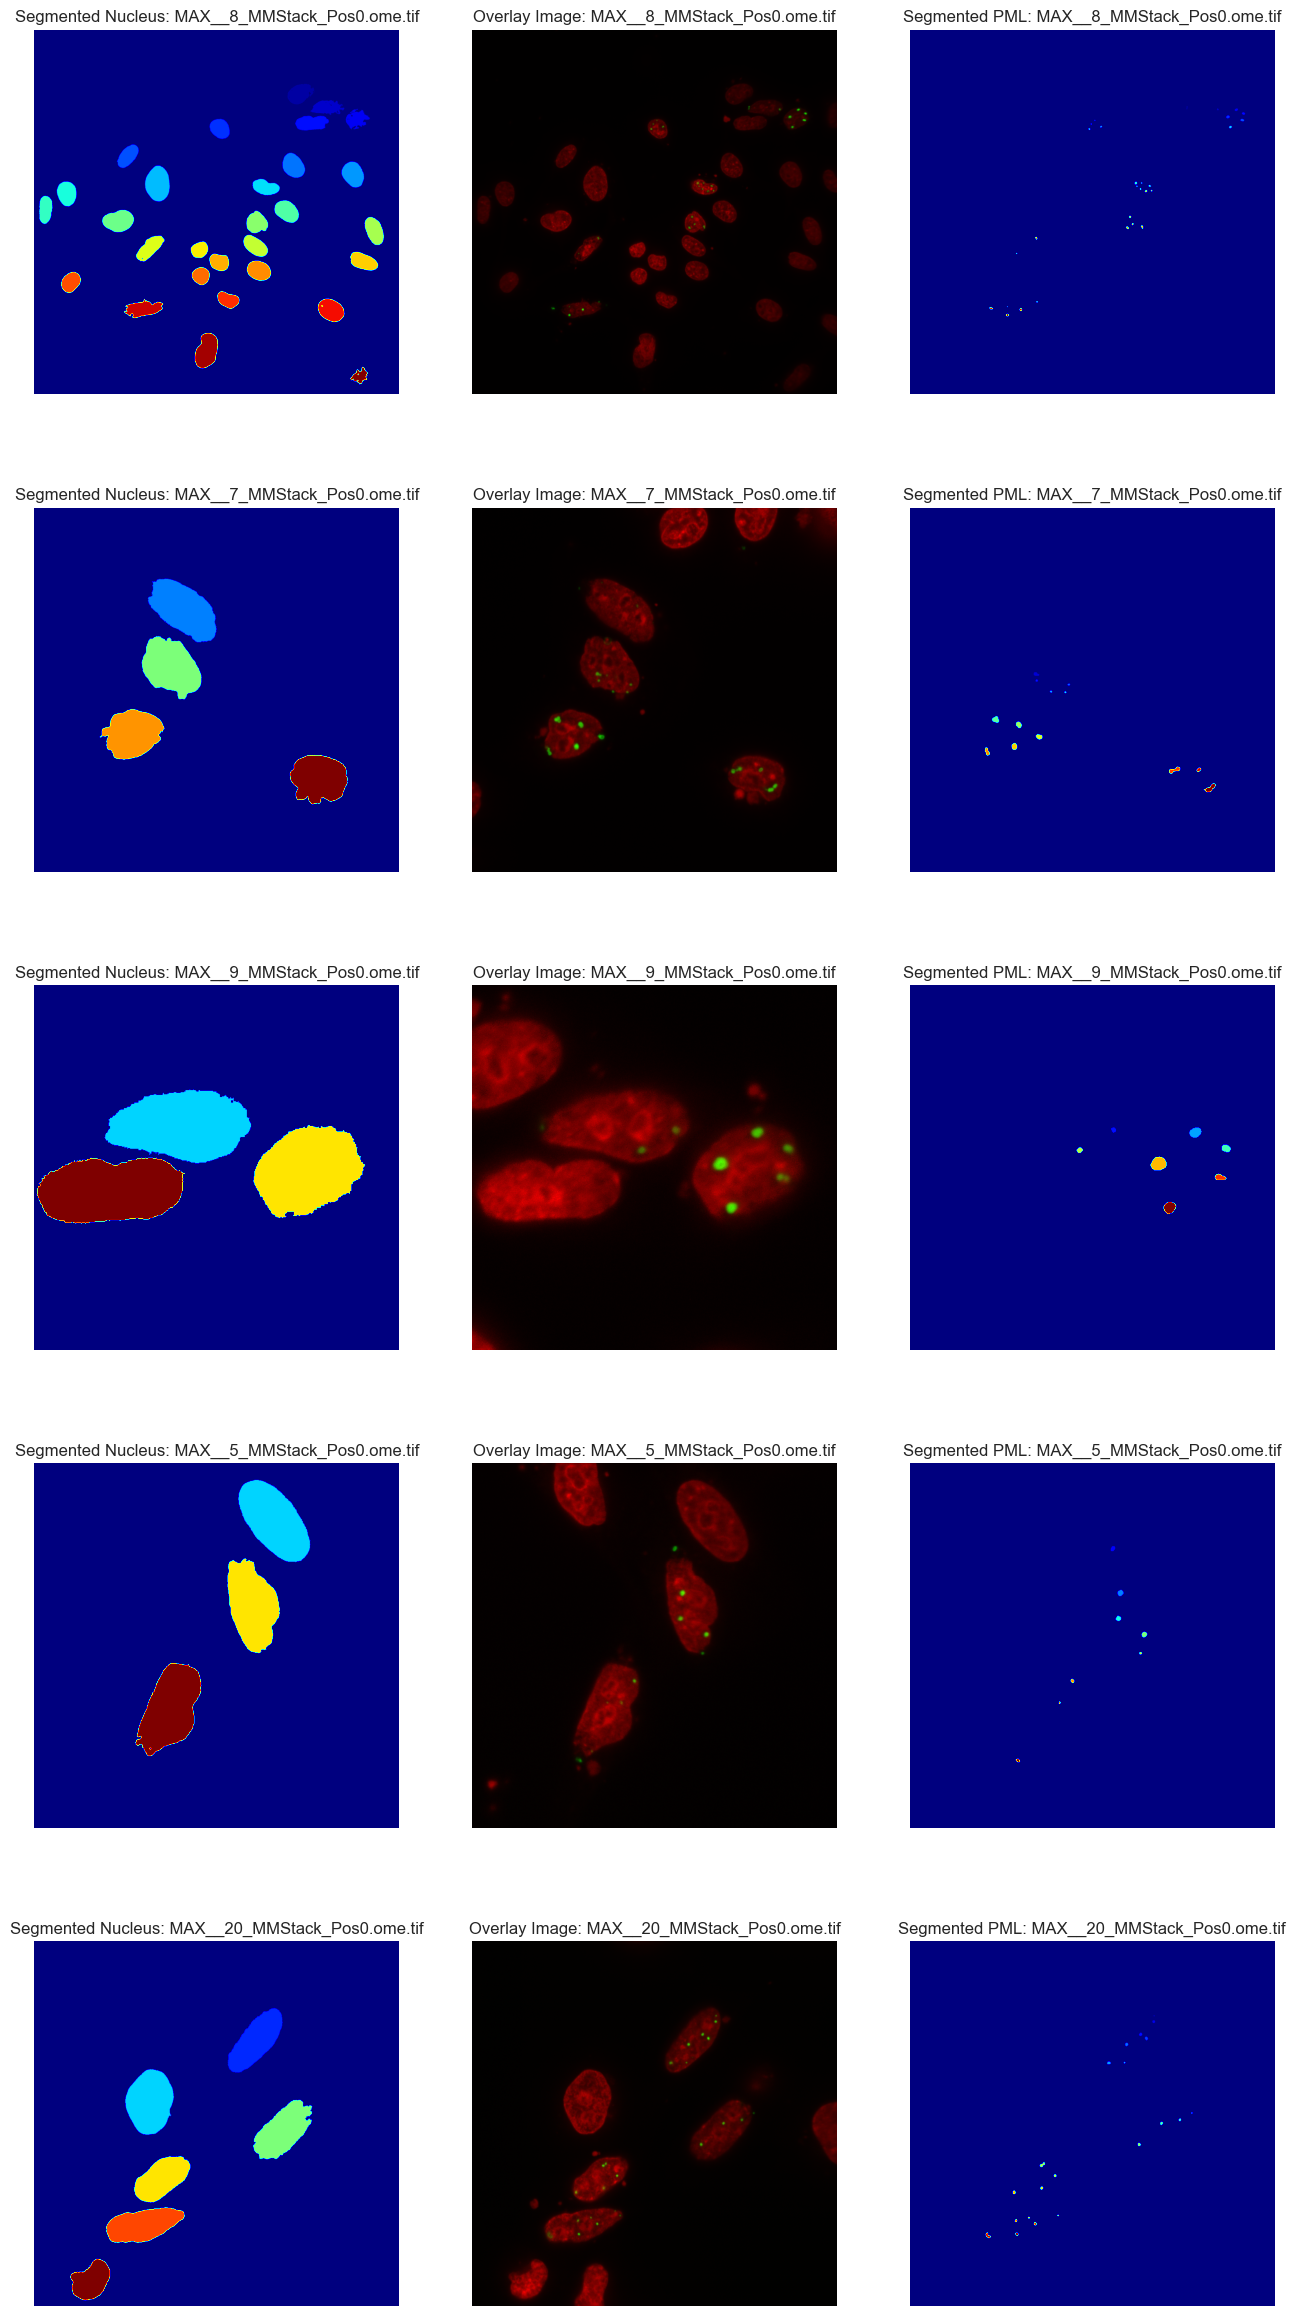

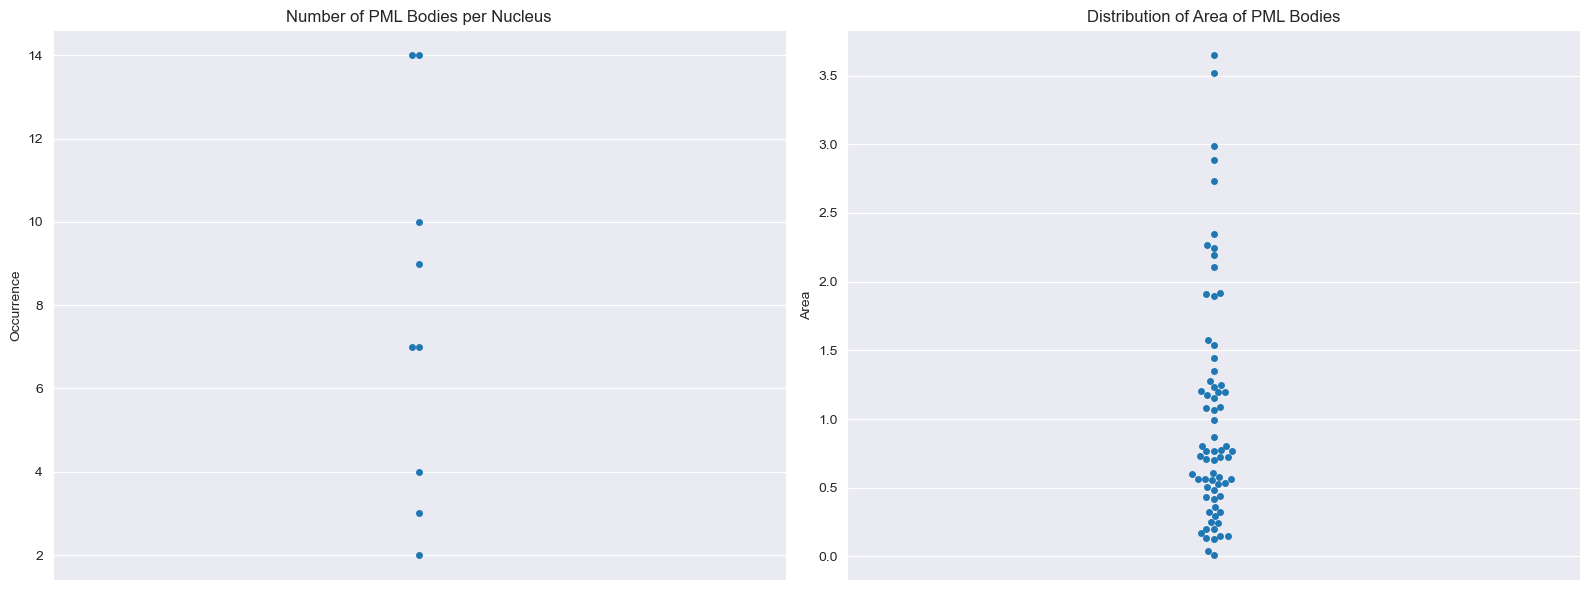

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, img_as_float, measure
from skimage.color import gray2rgb
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label as sk_label  # Rename label function
from skimage.morphology import closing, square, remove_small_objects

# Define the folder path containing OME-TIFF files
folder_path = "/Users/zg/Mammouth/PROJECTS/Analysis/Image_Choice/PML-choice/emGFP-PMLwt-z-max"

# List all OME-TIFF files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.ome.tif')]

# Initialize final_result DataFrame
final_result = pd.DataFrame()

# Create subplots
fig, axes = plt.subplots(len(file_list), 3, figsize=(16, 6 * len(file_list)))

# Process each file
for i, file_name in enumerate(file_list):
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)
    
    # Read the OME-TIFF file
    multi_channel_image = io.imread(file_path)
    
    # Check the shape of the multi-channel image
    print(f"Processing file {file_name}, shape: {multi_channel_image.shape}")
    
    # Ensure the image has the expected number of channels
    if multi_channel_image.ndim != 3 or multi_channel_image.shape[0] < 2:
        print(f"File {file_name} does not have enough channels or has an unexpected shape.")
        continue
    
    # Split the channels
    nucleus_image = multi_channel_image[1, :, :]
    pml_image = multi_channel_image[0, :, :]
    
    # Convert to float and normalize
    nucleus_image = img_as_float(nucleus_image)
    pml_image = img_as_float(pml_image)
    
    nucleus_image = (nucleus_image - nucleus_image.min()) / (nucleus_image.max() - nucleus_image.min())
    pml_image = (pml_image - pml_image.min()) / (pml_image.max() - pml_image.min())
    
     # Segmentation using Otsu's method for nucleus
    thresh_Nuc = threshold_otsu(nucleus_image)
    bw_Nuc = closing(nucleus_image > thresh_Nuc, square(3))  # Adjusted square size for nucleus
    cleared_Nuc = remove_small_objects(clear_border(bw_Nuc), 2000)  # Adjusted min_size for nucleus
    label_image_Nuc = sk_label(cleared_Nuc)  # Call renamed label function for nucleus
    
    # Segmentation using Otsu's method for PML
    thresh_PML = threshold_otsu(pml_image)
    bw_PML = closing(pml_image > thresh_PML, square(10))  # Adjusted square size for PML
    cleared_PML = remove_small_objects(clear_border(bw_PML), 5)  # Adjusted min_size for PML
    label_image_PML = sk_label(cleared_PML)  # Call renamed label function for PML
    
    # Get unique label values from the label image for nucleus
    unique_labels_nuc = np.unique(label_image_Nuc)
    unique_labels_nuc = unique_labels_nuc[unique_labels_nuc != 0]

    # Display the segmented nucleus
    axes[i, 0].imshow(label_image_Nuc, cmap='jet')
    axes[i, 0].set_title(f'Segmented Nucleus: {file_name}')
    axes[i, 0].axis('off')
    
    # Extract each ROI by its label value and calculate region properties
    for label in unique_labels_nuc:
        # Extract the ROI with the current label value
        roi = np.where(label_image_Nuc == label, 1, 0)
        
        # Calculate the product with the PML intensity image
        Product = roi * label_image_PML
        
        # Measure region properties, specifying the intensity image
        region_properties = measure.regionprops_table(Product, intensity_image=pml_image, properties=['area', 'mean_intensity'])
        
        # Create a DataFrame for the current region properties
        df = pd.DataFrame(region_properties)
        
        # Add the nucleus label to the DataFrame
        df['nucleus'] = label
        
        # Append the current DataFrame to the final result
        final_result = pd.concat([final_result, df], ignore_index=True)

    # Display the images
    nucleus_rgb = gray2rgb(nucleus_image)
    overlay_image = nucleus_rgb.copy()
    overlay_image[..., 0] = nucleus_image  # Red channel for nucleus
    overlay_image[..., 1] = pml_image      # Green channel for PML
    overlay_image[..., 2] = 0              # Blue channel remains 0
    
    axes[i, 1].imshow(overlay_image)
    axes[i, 1].set_title(f'Overlay Image: {file_name}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(label_image_PML, cmap='jet')
    axes[i, 2].set_title(f'Segmented PML: {file_name}')
    axes[i, 2].axis('off')

# Group by 'nucleus' and calculate the required statistics
grouped_stats = final_result.groupby('nucleus').agg(
    occurrence=('nucleus', 'size'),           # Count the number of entries for each nucleus
    mean_area=('area', 'mean'),               # Calculate the mean area for each nucleus
    mean_intensity=('mean_intensity', 'mean') # Calculate the mean intensity for each nucleus
).reset_index()

# Define the pixel size and calculate the pixel area
pix_size = 6.45 / 63
pix_size_square = pix_size ** 2

# Multiply the 'area' column by the pixel size squared
final_result['area'] = final_result['area'] * pix_size_square

# Merge the statistics back into the final_result DataFrame
final_result = pd.merge(final_result, grouped_stats, on='nucleus', how='left')

# Print the final result
print(final_result)

# Create side-by-side swarmplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the number of PML bodies per nucleus
sns.swarmplot(data=grouped_stats, y='occurrence', ax=axes[0])
axes[0].set_title('Number of PML Bodies per Nucleus')
axes[0].set_ylabel('Occurrence')

# Plot the distribution of area of the entire population of PML bodies
sns.swarmplot(data=final_result, y='area', ax=axes[1])
axes[1].set_title('Distribution of Area of PML Bodies')
axes[1].set_ylabel('Area')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()


In [4]:
print(grouped_stats)

   nucleus  occurrence   mean_area  mean_intensity
0        1           9   52.333333        0.403601
1        2          14  117.357143        0.449461
2        3          14  103.642857        0.429180
3        4           7  143.857143        0.417346
4        5          10   58.300000        0.362310
5       10           7  104.714286        0.343343
6       15           4  148.500000        0.380113
7       18           2   80.500000        0.313231
8       27           3   74.333333        0.415645
